In [1]:
# import opencv-python 
# import sleap
import json
import os
from pprint import pprint

In [2]:
sleap.disable_preallocation()
sleap.system_summary()
sleap.versions()

GPUs: 1/1 available
  Device: /physical_device:GPU:0
         Available: True
        Initalized: False
     Memory growth: True
SLEAP: 1.3.3
TensorFlow: 2.7.0
Numpy: 1.19.5
Python: 3.7.12
OS: Linux-5.15.0-101-generic-x86_64-with-debian-bullseye-sid


2024-04-01 10:44:39.572601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-01 10:44:39.576450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-01 10:44:39.576547: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Load MARS data
First, we'll need to convert the manifest files into something that SLEAP can read -- easiest is probably COCO


In [2]:
# label_manifest = '/home/kevin/Downloads/OpenField_Data/output_open_paws.manifest'
label_json = '/home/klb807/MARS_project/3d/annotation_data/processed_keypoints.json'


In [5]:
# # manifest version
# # open and start parsing file
# with open(label_manifest) as fid:
#     anns = []
#     for line in fid:
#         anns.append(json.loads(line))
# nodes = [result['label'].lstrip() for result in eval(anns[0]['annotatedResult']['annotationsFromAllWorkers'][0]['annotationData']['content'])['annotatedResult']['keypoints']]


# json version
with open(label_json, 'r') as fid:
    anns = json.load(fid)
    # print(tt)
#     anns = eval(fid.read())
# nodes = anns[0]['ann_label']

nodes = [label for ann in anns for label in ann['ann_label']]

# initialize the skeleton
# skeleton = sleap.Skeleton()
# skeleton.add_nodes(nodes)



In [5]:
# connect some stuff. probably not necessary
# skeleton.add_edge('nose','throat')
# skeleton.add_edge('throat','body center')
# skeleton.add_edge('body center','right hip')
# skeleton.add_edge('body center','left hip')
# skeleton.add_edge('right hip','tail base')
# skeleton.add_edge('left hip','tail base')
# skeleton.add_edge('tail base','tail mid')
# skeleton.add_edge('tail mid','tail tip')

# for the multiview 3d tracking
# skeleton.add_edge('Nose','Right Ear')
# skeleton.add_edge('Nose','Left Ear')
skeleton.add_edge('Nose','Throat')
skeleton.add_edge('Throat','Right Ear')
skeleton.add_edge('Throat','Left Ear')
skeleton.add_edge('Throat','Spine Center')
skeleton.add_edge('Spine Center','Tail Base')
skeleton.add_edge('Tail Base','Tail Middle')
skeleton.add_edge('Tail Middle','Tail Tip')
skeleton.add_edge('Tail Base','Right Knee')
skeleton.add_edge('Tail Base','Left Knee')
skeleton.add_edge('Right Knee','Right Rear Paw')
skeleton.add_edge('Left Knee','Left Rear Paw')
skeleton.add_edge('Spine Center','Right Front Paw')
skeleton.add_edge('Spine Center','Left Front Paw')

In [ ]:

data_path = '/home/klb807/MARS_project/3d/annotation_data/raw_images/pad/'
# manifest version
# frame_names = [data_path + os.path.split(ann['source-ref'])[-1] for ann in anns if 'annotatedResult' in ann.keys()]
# # json version
frame_names = [data_path + os.path.split(ann['image'])[-1] for ann in anns]

video = sleap.Video.from_image_filenames(filenames=frame_names)


In [ ]:
# manifest version

# create a labeled frame iterator
lab_frame = []
img_id = 0
# iterate through the images
for ann in anns:

    # if the file wasn't annotated, skip
    if 'annotatedResult' not in ann.keys():
        continue

    # get the image name
    img_name = os.path.split(ann['source-ref'])[-1]
    img_id = video.get_idx_from_filename(data_path+img_name)
    
    instances = []
    for w, worker_result in enumerate(ann['annotatedResult']['annotationsFromAllWorkers']):
        # results for each worker are embeded as a string
        annot = eval(worker_result['annotationData']['content'])['annotatedResult']

        keypoint_dict = {item['label'].lstrip():sleap.instance.Point(x=item['x'], y=item['y'])
                         for item in annot['keypoints']}
        
        # append the list
        instance = sleap.Instance(skeleton=skeleton, points=keypoint_dict)
        instances.append(instance)

        labeled_frame = sleap.LabeledFrame(video=video, frame_idx = img_id, instances=instances)

    # put the instances into the labeled frame list
    lab_frame.append(labeled_frame)

In [7]:
# json version

# create a labeled frame iterator
lab_frame = []
# iterate through the images
for ann in anns:

    height = ann['height']
    width = ann['width']

    # get the image name
    img_name = os.path.split(ann['image'])[-1]
    img_id = video.get_idx_from_filename(data_path+img_name)
    
    instances = []
    keypoint_dict = {ann_label:sleap.instance.Point(x=ann['ann_black']['X'][0][ii]*width,y=ann['ann_black']['Y'][0][ii]*height)
                     for ii,ann_label in enumerate(ann['ann_label'])}
    instance = sleap.Instance(skeleton=skeleton, points=keypoint_dict)
    instances.append(instance)

    labeled_frame = sleap.LabeledFrame(video=video, frame_idx=img_id, instances=instances)

    # put the instances into the labeled frame list
    lab_frame.append(labeled_frame)

In [8]:
output_labels = sleap.Labels(lab_frame)

In [10]:
video[1000]

array([[[[36, 36, 36],
         [36, 36, 36],
         [36, 36, 36],
         ...,
         [38, 38, 38],
         [38, 38, 38],
         [36, 36, 36]],

        [[36, 36, 36],
         [36, 36, 36],
         [36, 36, 36],
         ...,
         [31, 31, 31],
         [31, 31, 31],
         [31, 31, 31]],

        [[34, 34, 34],
         [34, 34, 34],
         [34, 34, 34],
         ...,
         [31, 31, 31],
         [31, 31, 31],
         [31, 31, 31]],

        ...,

        [[93, 93, 93],
         [92, 92, 92],
         [91, 91, 91],
         ...,
         [73, 73, 73],
         [73, 73, 73],
         [74, 74, 74]],

        [[88, 88, 88],
         [88, 88, 88],
         [85, 85, 85],
         ...,
         [72, 72, 72],
         [73, 73, 73],
         [73, 73, 73]],

        [[85, 85, 85],
         [85, 85, 85],
         [85, 85, 85],
         ...,
         [70, 70, 70],
         [74, 74, 74],
         [72, 72, 72]]]], dtype=uint8)

In [32]:
output_labels[8]

LabeledFrame(video=SingleImageVideo('/home/klb807/MARS_project/3d/annotation_data/raw_images/Basler_acA1300-60gm__24254439__20231101_114651285_00001655_West.png'), frame_idx=8, instances=1)

['Nose', 'Right Ear', 'Left Ear', 'Throat', 'Spine Center', 'Right Knee', 'Left Knee', 'Right Front Paw', 'Left Front Paw', 'Right Rear Paw', 'Left Rear Paw', 'Tail Base', 'Tail Middle', 'Tail Tip']


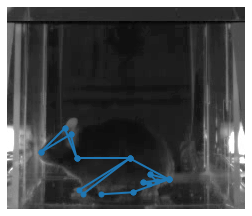

In [61]:
import random

for labeled in random.choices(output_labels, k = 1):
    labeled.plot()
    names = [node_point[0].name for node_point in labeled.instances[0].nodes_points]
    print(names)


In [12]:
labeled.instances[0].nodes_points

dict_items([(Node(name='Nose', weight=1.0), Point(x=213.0, y=189.0, visible=True, complete=False)), (Node(name='Right Ear', weight=1.0), Point(x=161.0, y=164.0, visible=True, complete=False)), (Node(name='Left Ear', weight=1.0), Point(x=185.0, y=143.0, visible=True, complete=False)), (Node(name='Throat', weight=1.0), Point(x=177.0, y=188.0, visible=True, complete=False)), (Node(name='Spine Center', weight=1.0), Point(x=123.0, y=139.0, visible=True, complete=False)), (Node(name='Right Knee', weight=1.0), Point(x=125.0, y=176.0, visible=True, complete=False)), (Node(name='Left Knee', weight=1.0), Point(x=129.0, y=159.0, visible=True, complete=False)), (Node(name='Right Front Paw', weight=1.0), Point(x=162.0, y=191.0, visible=True, complete=False)), (Node(name='Left Front Paw', weight=1.0), Point(x=167.0, y=184.0, visible=True, complete=False)), (Node(name='Right Rear Paw', weight=1.0), Point(x=111.00000000000001, y=185.0, visible=True, complete=False)), (Node(name='Left Rear Paw', weight

In [27]:
missing_frames = []


for labeled_frame in output_labels:
    names = [node_point[0].name for node_point in labeled_frame.instances[0].nodes_points]
    if len(names) < len(nodes):
        missing_frames.append(labeled_frame.video.backend.filename)


In [ ]:
output_labels[1000]

In [62]:
output_labels.save('processed_open_combined.slp',with_images=False)

In [ ]:
!sleep-train '~/Downloads/baseline_large_rf.single.json' processed_open_combined.slp

In [ ]:
os.getcwd()

In [29]:
#json version
missing_dict = {}
missing_count = 0

for ann in anns:

    height = ann['height']
    width = ann['width']

    missing_list = [ann_label for ii,ann_label in enumerate(ann['ann_label'])
                    if (ann['ann_black']['X'][0][ii] == 0) and (ann['ann_black']['Y'][0][ii] == 0)]

    if len(missing_list) > 0:
        missing_dict[ann['image']] = missing_list 
    missing_count += len(missing_list)

    
    

In [ ]:
anns[490]

In [ ]:
# manifest version
missing_count = 0
missing_dict = dict()

nodes = [result['label'].lstrip() for result in eval(anns[0]['annotatedResult']['annotationsFromAllWorkers'][0]['annotationData']['content'])['annotatedResult']['keypoints']]

for ann in anns:
    # keypoints
    keypoints = eval(ann['annotatedResult']['annotationsFromAllWorkers'][0]['annotationData']['content'])['annotatedResult']['keypoints']
    
    missing_list = [keypoint['label'].lstrip() for keypoint in keypoints if (keypoint['x'] == 0) and (keypoint['y'] == 0)]

    if len(missing_list) > 0:
        missing_dict[ann['image']] = missing_list 
    missing_count += len(missing_list)



In [ ]:
import pandas as pd
import numpy as np

In [ ]:
keypoint_pd = pd.DataFrame()
for ii_ann,ann in enumerate(anns):
    # skip anything without annotations
    # if 'annotatedResult' not in ann.keys():
    #     continue

    # keypoints = eval(ann['annotatedResult']['annotationsFromAllWorkers'][0]['annotationData']['content'])['annotatedResult']['keypoints']
    # kp_dict = {kp['label'].lstrip():[[kp['x'],kp['y']]] for kp in keypoints}

    kp_dict = {label:[[ann['ann_black']['X'][0][ii],ann['ann_black']['Y'][0][ii]]] for ii,label in enumerate(ann['ann_label'])}
    kp_dict['filename'] = ann['image'].split('/')[-1]
    keypoint_pd = pd.concat([keypoint_pd, pd.DataFrame.from_dict(kp_dict)], ignore_index=True)



In [ ]:
print([file[-50:] for file in keypoint_pd.loc[keypoint_pd.isna().any(axis=1)]['filename'][:5]])

In [ ]:
sleap.nn.training.CentroidConfmapsModelTrainer()